# Prova 2 - Calculo Numérico (SME-0104)

## Professor: Antonio Castelo Filho

## Aluno: Alvaro José Lopes (10873365)

---


In [213]:
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from sklearn.metrics import mean_squared_error
!pip install bezier
import bezier
from sklearn.decomposition import PCA
from scipy.optimize import least_squares

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Questão 1 (3 pontos)

Escolha uma imagem em tons de cinza com resolução pelo menos 128x128.
Utilize a decomposição SVD para comprimir esta imagem com taxa de compressão de
pelo menos 30% e compare as duas imagens para garantir a qualidade (olhe o erro:
norma_matricial(imagem original – imagem comprimida)).

---
#### Resposta:

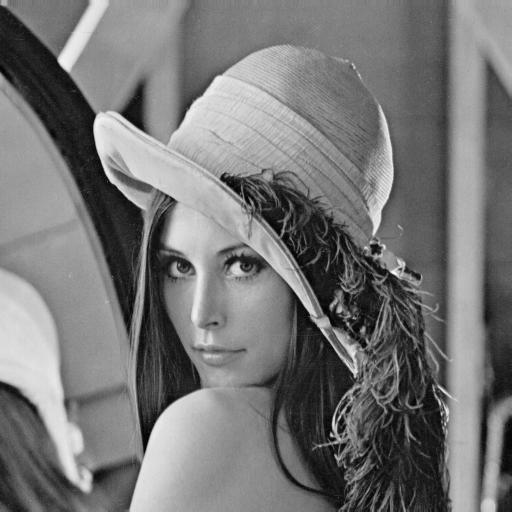

In [214]:
# Importando imagem de exemplo
url = 'https://raw.githubusercontent.com/AlvaroJoseLopes/P2-Numerical-Methods/master/lena.jpg'
page = requests.get(url)
img = Image.open(BytesIO(page.content)).convert('LA')
img

(512, 512)


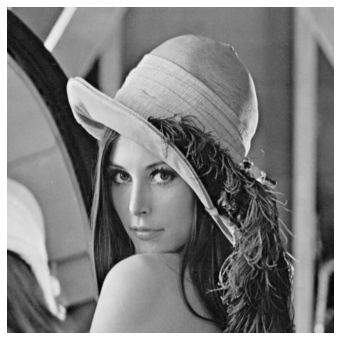

In [215]:
# transformando a imagem em uma matriz
X = np.asarray(img)[:,:,0]
print(X.shape)

plt.axis('off')
plt.imshow(X,cmap='gray')

A aproximação de posto reduzido da decomposição SVD será usada para compressão de imagem.

A matriz $\mathbf{A}_r=\mathbf{U}_k\Sigma_k\mathbf{V}_k^\top$ será a aproximação de posto $k$ para a matriz $\mathbf{A}=\mathbf{U}\Sigma\mathbf{V}^\top$, obtida a partir da decomposição SVD.

Uma vez que estamos pegando o posto reduzido dessa matriz será necessário armazenar uma matriz menor correspondente à imagem, reduzindo a quantidade de memória para armazená-la.

In [216]:
# Realizando a decomposição SVD
U, sigma, V = np.linalg.svd(X)

In [217]:
def plot_compressed_img_report(X, U, sigma, V, k):
    # Comprimindo
    compressed_X = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])
    
    # Calculando a taxa de compressão
    bits_X = X.itemsize*X.shape[0]*X.shape[1]
    bits_compressed = X.itemsize * k * (X.shape[0]+X.shape[1])
    compression_rate = round(100 * (bits_compressed / bits_X), 2)

    # Calculando o erro
    norm = np.linalg.norm(X - compressed_X)
    
    plt.figure(figsize=(10,10))
    plt.imshow(compressed_X, cmap='gray')
    plt.axis('off')
    plt.title(f'k = {k}\ntaxa de compressão = {compression_rate}\nerro = {round(norm, 2)}')
    plt.show()

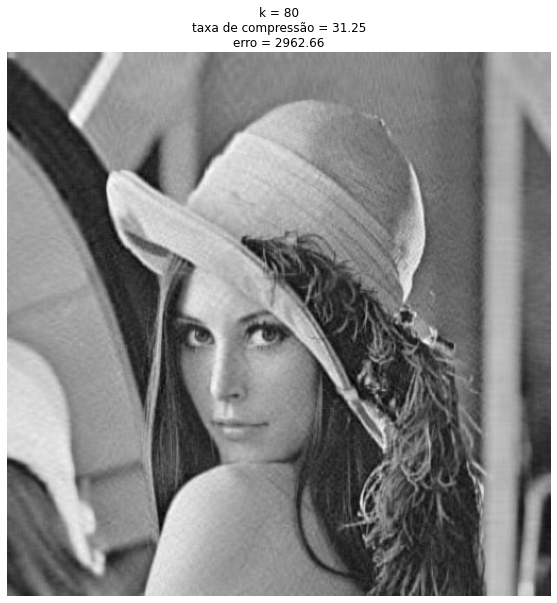

In [218]:
k = 80
plot_compressed_img_report(X, U, sigma, V, k)

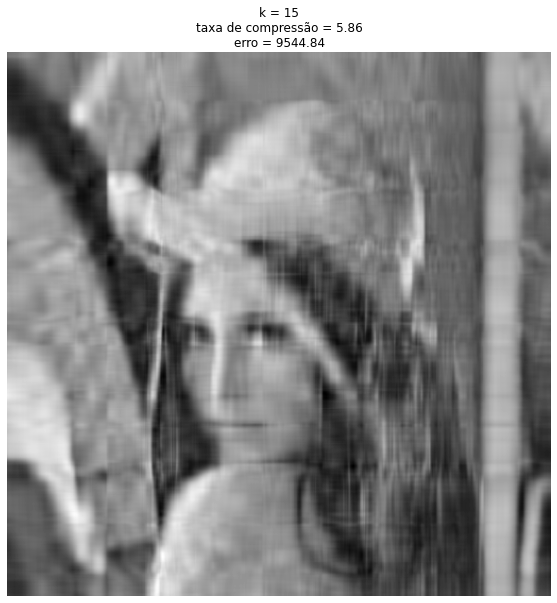

In [219]:
k = 15
plot_compressed_img_report(X, U, sigma, V, k)

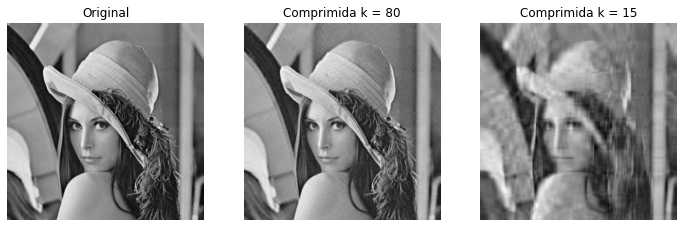

In [220]:
# Comparando os resultados
k = 80
compressed_X_80 = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])
k = 15
compressed_X_15 = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])

plt.rcParams['figure.figsize'] = [12, 6]
fig,(ax1, ax2, ax3) = plt.subplots(1,3)
ax1.axis('off')
ax1.imshow(X,cmap='gray')
ax1.set_title('Original')
ax2.axis('off')
ax2.imshow(compressed_X_80,cmap='gray')
ax2.set_title(f'Comprimida k = 80')
ax3.axis('off')
ax3.imshow(compressed_X_15,cmap='gray')
ax3.set_title(f'Comprimida k = 15')
plt.show()

Pode-se observar que, a depender da aproximação de posto $k$ escolhida, é possível preservar a qualidade da imagem. Quanto menor o $k$ escolhido maior será o erro e, consequentemente, maior será a perda da qualidade da imagem, apesar de sua maior compressão.  

## Questão 2 (3 pontos)

Considere os pontos no plano $(x_i, y_i)$, onde $x_i = cos(t_i)$ e $y_i = sin(t_i)$, $t_i
= 0:pi/200:pi/2$. 

Utiliza PCA para encontrar a reta que melhor aproxime esta curva,
encontrando a maior componente principal.
Aproxime agora pelo método dos mínimos quadrados por uma reta.
Compare as duas retas e comente o resultado.

---
Resposta:

### Obtendo os dados

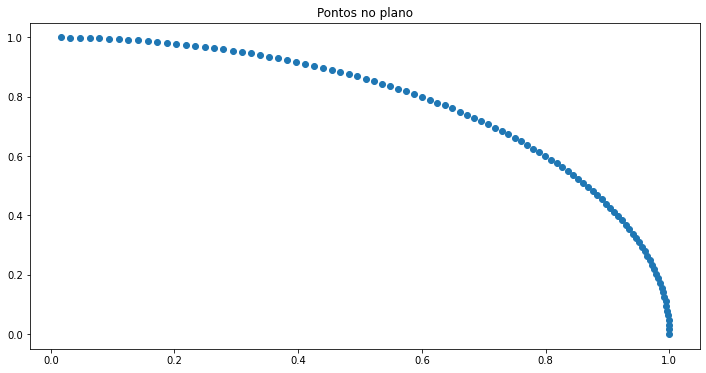

In [221]:
dom_t = np.arange(0, np.pi/2, np.pi/200)
x = (lambda t: np.cos(t)) (dom_t)
y = (lambda t: np.sin(t)) (dom_t)

plt.scatter(x,y)
plt.title('Pontos no plano')
plt.show()

### Usando PCA

No PCA será usada a maior componente principal para realizar a mudança de base dos pontos requisitados, dados em $\mathbb{R}^2$, para $\mathbb{R}^1$. Ou seja, queremos apenas uma componente principal.

Em seguida, a componente principal será usada para obter uma reta. Para isso será necessário obter o autovetor correspondente à essa componente principal e um ponto qualquer da reta em \mathbb{R}^2.

In [222]:
# Construindo o par (x,y)
xy = np.column_stack([x,y])
pca = PCA(n_components = 1)

# pares reduzidos em 1 dimensão (nova base dada pelo PCA -> de maior componente principal)
xy_reduced = pca.fit_transform(xy)

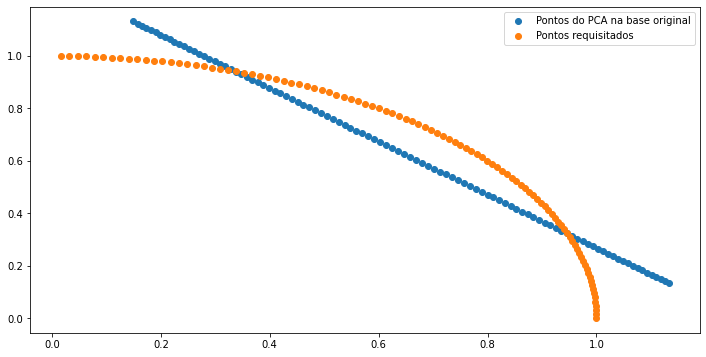

In [223]:
# Retornando a coordenada para a base inicial (x,y) 'predito'
xy_pred = pca.inverse_transform(xy_reduced)
plt.scatter(xy_pred[:,0], xy_pred[:,1], label = 'Pontos do PCA na base original')
plt.scatter(x,y, label = 'Pontos requisitados')
plt.legend()
plt.show()

In [224]:
# Função para calcular os valores de 'a' e 'b'
# da reta f = b + a * x
def get_pcaEquation(x,y,vec):
    a = vec[1]/vec[0]
    b = y - a * x 
    return a, b

# Autovetor e ponto da amostra
vec = pca.components_[0]
sample_point = xy_pred[50]

a, b = get_pcaEquation(sample_point[0], sample_point[1], vec)
print(f'Equação da reta gerada pelo PCA: {round(a, 3)} * x + {round(b, 3)}')
f_pca = lambda x: a * x + b
y_pca = f_pca(x)

Equação da reta gerada pelo PCA: -1.016 * x + 1.283


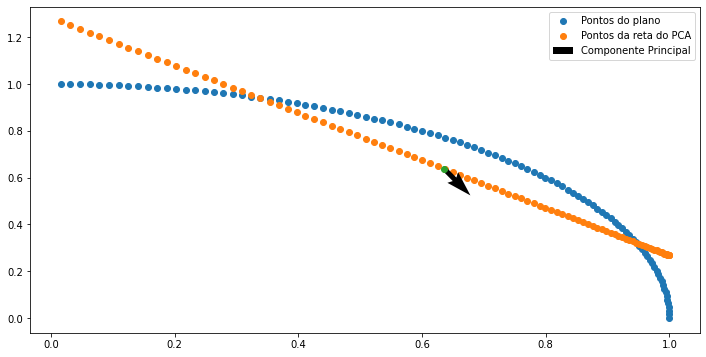

In [225]:
plt.scatter(x, y, label='Pontos do plano')
plt.scatter(x, y_pca, label='Pontos da reta do PCA')
plt.quiver(sample_point[0], sample_point[1], vec[0], vec[1], label='Componente Principal')
plt.scatter(*sample_point)
plt.legend()
plt.show()

In [226]:
print(f'Erro Quadrático médio: {mean_squared_error(y, y_pca)}')
print(f'Erro Quadrático médio (Arredondando em 3 casas decimais): {round(mean_squared_error(y, y_pca), 3)}')

Erro Quadrático médio: 0.01572060964201279
Erro Quadrático médio (Arredondando em 3 casas decimais): 0.016


### Método dos Mínimos Quadrados

O método dos mínimos quadrados será usado para encontrar os coeficientes $a$ e $b$ da reta:

$$f(x) = a \cdot x + b$$

O método na biblioteca numpy utilizado aproxima a solução da equação:

$$Ax = b$$

Em que $A$ é a matriz de coeficientes.

In [227]:
# Montando a matriz de coeficientes
A = np.vstack([x, np.ones(len(x))]).T
# Usando MMQ para calcular os coeficientes a e b
a, b = np.linalg.lstsq(A,y)[0]

# Obtendo a equação da reta
f_mmq = lambda x: b + a * x
y_mmq = f_mmq(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [228]:
print(f'Equação da reta gerada pelo Método dos Mínimos Quadrados: {round(a, 3)} * x + {round(b, 3)}')


Equação da reta gerada pelo Método dos Mínimos Quadrados: -0.932 * x + 1.229


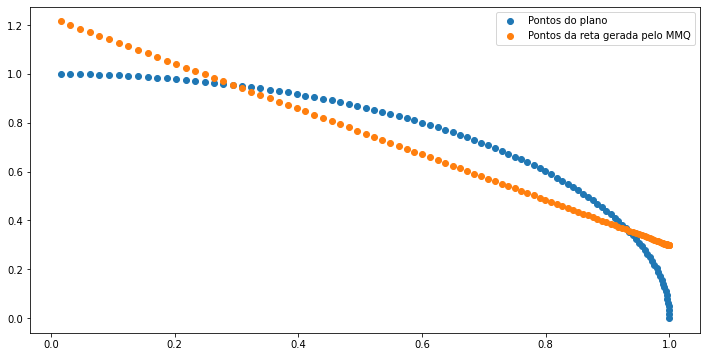

In [229]:
plt.scatter(x, y, label='Pontos do plano')
plt.scatter(x, y_mmq, label='Pontos da reta gerada pelo MMQ')
plt.legend()
plt.show()

In [230]:
print(f'Erro Quadrático médio: {mean_squared_error(y, y_mmq)}')
print(f'Erro Quadrático médio (Arredondando em 3 casas decimais): {round(mean_squared_error(y, y_mmq), 3)}')

Erro Quadrático médio: 0.015058850740034881
Erro Quadrático médio (Arredondando em 3 casas decimais): 0.015


### Comparando as duas retas

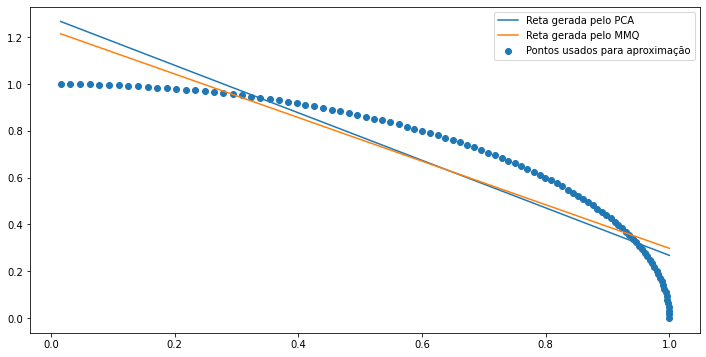

In [231]:
plt.plot(x, y_pca, label='Reta gerada pelo PCA')
plt.plot(x, y_mmq, label='Reta gerada pelo MMQ')
plt.scatter(x,y, label='Pontos usados para aproximação')
plt.legend()
plt.show()

A tabela a seguir resume os erros de cada aproximação:

| Método de Interpolação | MSE | Equação da reta obtida |
|------|------|------|
| PCA | 0.016 | $-1.016x + 1.283$ |
| MMQ | 0.015 | $-0.932x + 1.229$ |

Pode-se notar que as retas obtidas possuem coeficientes muitos parecidos, e, consequentemente, apresentaram erros na aproximação muito próximos. 

Essa ligeira diferença deve-se ao fato dos métodos utilizarem diferentes formas para aproximar uma reta. O método do PCA usa o vetor da componente principal para gerar a reta, enquanto o Método dos Mínimos Quadrados busca a solução da equação matricial $Ax=b$ que minimiza a norma $\lVert b-ax\rVert$.

## Questão 3 (4 pontos)

Considere a função do fenômeno de Runge com 11 pontos igualmente
espaçados no intervalo $[-1, 1]$. Interpole utilizando:

---
### Resposta


In [232]:
# Pontos de interpolação
X = np.linspace(-1,1, 11)
# Função de Rung
runge_function = lambda x: 1/(1+(25*x**2))
y = runge_function(X)

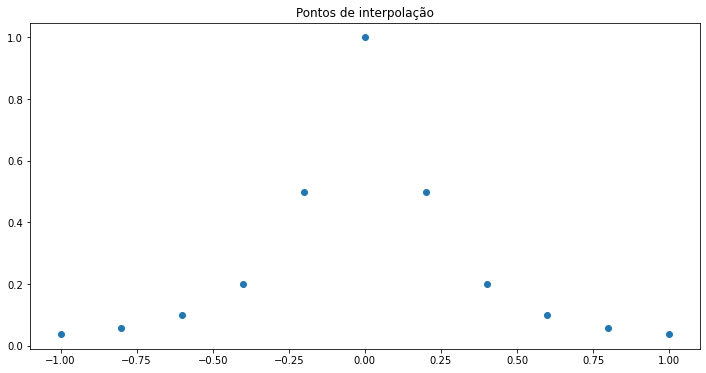

In [233]:
plt.scatter(X, y)
plt.title('Pontos de interpolação')
plt.show()

In [234]:
# Domínio de X
dom_X = np.linspace(-1,1,100)
y_true = runge_function(dom_X)

In [235]:
# Função auxiliar para plotar a interpolação + função de Runge + pontos de interpolação
def plotInterpolation(X, dom_X, y_true, y_pred, label):
    plt.figure(figsize=(8,8))
    plt.scatter(X, y, label = 'Pontos de interpolação')
    plt.plot(dom_X, y_pred, '--', label=label)
    plt.plot(dom_X, runge_function(dom_X), label='Função de Runge')
    plt.legend()
    plt.show()

#### a) Um único polinômio


In [236]:
poly = interpolate.lagrange(X, y)
y_pred_poly = poly(dom_X)

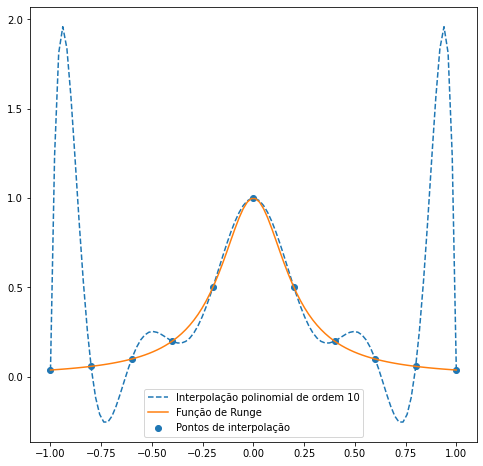

In [237]:
plotInterpolation(X, dom_X, y_true, y_pred_poly, f'Interpolação polinomial de ordem {poly.order}')

In [238]:
print(f'Erro Quadrático médio: {mean_squared_error(y_true, y_pred_poly)}')
print(f'Erro Quadrático médio (Arredondando em 3 casas decimais): {round(mean_squared_error(y_true, y_pred_poly), 3)}')

Erro Quadrático médio: 0.3332434080623166
Erro Quadrático médio (Arredondando em 3 casas decimais): 0.333


#### b) Splines cúbicos com condição de fronteira natural

In [239]:
cubic_spline = interpolate.CubicSpline(X,y)
y_pred_cubic_spline = cubic_spline(dom_X)

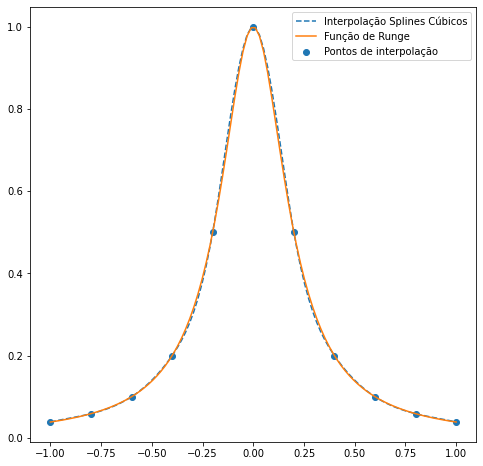

In [240]:
plotInterpolation(X, dom_X, y_true, y_pred_cubic_spline, f'Interpolação Splines Cúbicos')

In [241]:
print(f'Erro Quadrático médio: {mean_squared_error(y_true, y_pred_cubic_spline)}')
print(f'Erro Quadrático médio (Arredondando em 3 casas decimais): {round(mean_squared_error(y_true, y_pred_cubic_spline), 3)}')

Erro Quadrático médio: 5.0979901118156426e-05
Erro Quadrático médio (Arredondando em 3 casas decimais): 0.0


#### c) Bezier considerando estes pontos como polígono de controle;

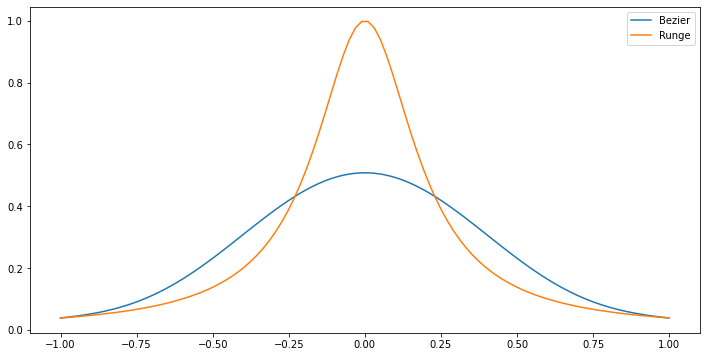

In [242]:
bz = bezier.curve.Curve(np.array([X,y]), degree=10)
y_pred_bezier = bz.evaluate_multi(np.linspace(0,1,100))[1]
plt.plot(dom_X, y_pred_bezier, label='Bezier')
plt.plot(dom_X, y_true, label='Runge')
plt.legend()
plt.show()

In [243]:
print(f'Erro Quadrático médio: {mean_squared_error(y_true, y_pred_bezier)}')
print(f'Erro Quadrático médio (Arredondando em 3 casas decimais): {round(mean_squared_error(y_true, y_pred_bezier), 3)}')

Erro Quadrático médio: 0.024732406295429065
Erro Quadrático médio (Arredondando em 3 casas decimais): 0.025


#### d) Bsplines cúbicas considerando estes pontos o polígono de controle;

In [244]:
bsplines = interpolate.splrep(X,y)
y_pred_bsplines = interpolate.BSpline(*bsplines)(dom_X)

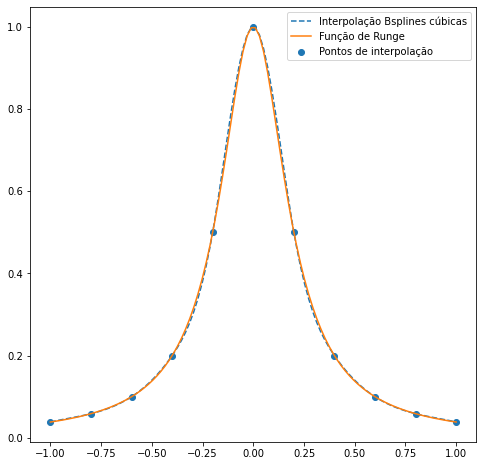

In [245]:
plotInterpolation(X, dom_X, y_true, y_pred_bsplines, f'Interpolação Bsplines cúbicas')

In [246]:
print(f'Erro Quadrático médio: {mean_squared_error(y_true, y_pred_bsplines)}')
print(f'Erro Quadrático médio (Arredondando em 3 casas decimais): {round(mean_squared_error(y_true, y_pred_bsplines), 3)}')

Erro Quadrático médio: 5.097990111815666e-05
Erro Quadrático médio (Arredondando em 3 casas decimais): 0.0


#### e) Discuta os resultados observando o erro cometido em cada um dos casos.

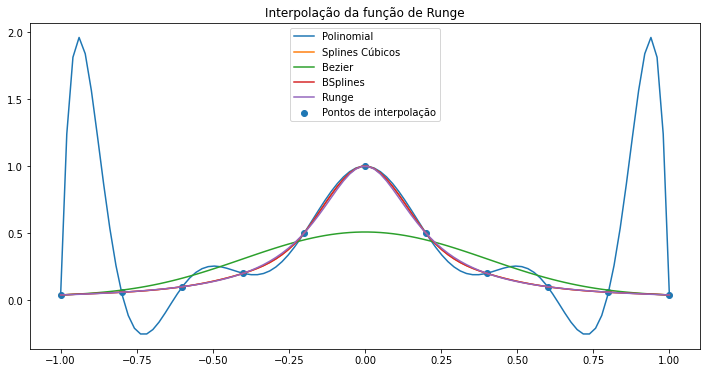

In [247]:
plt.scatter(X,y, label='Pontos de interpolação')
plt.plot(dom_X, y_pred_poly, label='Polinomial')
plt.plot(dom_X, y_pred_cubic_spline, label='Splines Cúbicos')
plt.plot(dom_X, y_pred_bezier, label='Bezier')
plt.plot(dom_X, y_pred_bsplines, label='BSplines')
plt.plot(dom_X, y_true, label='Runge')
plt.title("Interpolação da função de Runge")
plt.legend()
plt.show()

Foi usado o erro quadrático médio como métrica de erro. A tabela a seguir resume os erros de cada método:

| Método de Interpolação | MSE (3 casas decimais)|
|------|------|
| Polinômio | 0.333 |
| Splines Cúbicos | 0.000 |
| Bezier | 0.025 |
| Bsplines cúbicas | 0.000 |



Comparando todos os métodos de interpolação e os seus respectivos erros, pode-se notar que a interpolação por Splines Cúbicos e Bsplines foram as que apresentaram o menor erro quadrático médio e obteram uma melhor aproximação para a função de Runge.

Analisando o resultado na interpolação Polinomial Lagrangeana, é possível observar o fenômeno de Runge, no qual o resultado da interpolação começa a oscilar à medida que a função começa a se aproximar das extremidades do intervalo analisado (neste caso, próximo de -1 e 1).

Ao observar a interpolação de Bezier é possível notar o impacto da posição dos pontos de controle na qualidade da curva obtida: nos pontos próximos de $x=0$ - no qual a taxa de crescimento/decrescimento da função de Runge é maior, e é onde está localizado o seu máximo - a curva obtida não se aproxima suficientemente bem da função de Runge. Isso se deve à má distribuição dos pontos de controle nessa região, uma vez que eles se concentram na região da curva em que a taxa de crescimento/decrescimento é menor. Seria necessário fornecer mais pontos de controle próximos do intervalo $[-0.25,0,25]$ para uma melhor interpolação. 

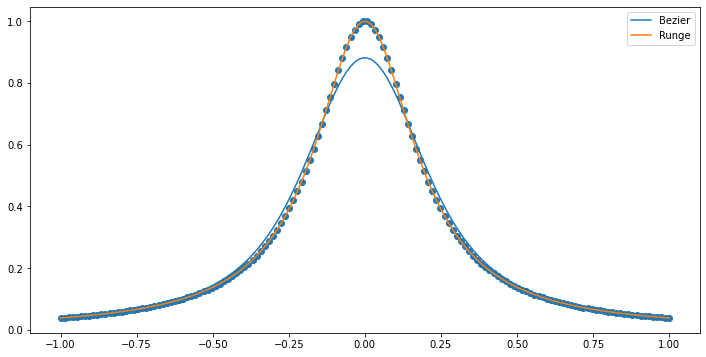

In [256]:
# Usando um numero maior de pontos de controle
n_control_points = 150
dom_X = np.linspace(-1, 1, n_control_points)
y_true = runge_function(dom_X)
bz = bezier.curve.Curve(np.array([dom_X,y_true]), degree=n_control_points-1)
y_pred_bezier = bz.evaluate_multi(np.linspace(0,1,n_control_points))[1]
plt.scatter(dom_X, y_true)
plt.plot(dom_X, y_pred_bezier, label='Bezier')
plt.plot(dom_X, y_true, label='Runge')
plt.legend()
plt.show()